In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import LabelEncoder
from sklearn import svm

# Set random seed
seed = 0

In [2]:
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')


In [3]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Columns: 635 entries, num__budget to category
dtypes: float64(634), object(1)
memory usage: 42.6+ MB
None
   num__budget  num__revenue  num__popularity  num__runtime  num__vote_count  \
0     4.757463      1.005269         0.425819      0.448734         1.716450   
1     2.894642      1.159981         0.366180     -0.230573         1.636140   
2     3.826052      2.100421         0.503760      0.739865         1.420090   
3     2.628524      0.670763         0.183190     -0.230573         1.375134   
4     1.510832      0.743000         0.159881     -0.085007         0.961366   

   num__release_year  num__release_month  cat__original_language_ar  \
0           0.483259           -0.241059                        0.0   
1           0.605583           -0.533445                        0.0   
2           0.789068           -0.241059                        0.0   
3           0.727906            0.343713               

# Score prediction

In [4]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])  # Replace with your target column


In [5]:
X = df.drop('category', axis=1)
Y = df['category']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


## SVM

In [6]:
clf = svm.SVC(gamma='auto', kernel='linear')


clf.fit(X_train, Y_train_encoded)
Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.6209447922595333


In [7]:
# Use randm search to find best hyperparameters
param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(1, 10),
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=seed, verbose=2, n_jobs=-1)
random_search.fit(X_train, Y_train_encoded)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END C=5.588135039273247, degree=6, gamma=scale, kernel=sigmoid; total time= 1.5min
[CV] END C=5.588135039273247, degree=6, gamma=scale, kernel=sigmoid; total time= 1.7min
[CV] END C=5.588135039273247, degree=6, gamma=scale, kernel=sigmoid; total time= 1.7min
[CV] END C=5.588135039273247, degree=6, gamma=scale, kernel=sigmoid; total time= 1.7min
[CV] END C=5.588135039273247, degree=6, gamma=scale, kernel=sigmoid; total time= 1.8min
[CV] END C=0.6671297731744318, degree=2, gamma=scale, kernel=sigmoid; total time= 2.3min
[CV] END C=8.679456176227568, degree=8, gamma=auto, kernel=sigmoid; total time= 2.9min
[CV] END C=8.679456176227568, degree=8, gamma=auto, kernel=sigmoid; total time= 2.9min
[CV] END C=8.679456176227568, degree=8, gamma=auto, kernel=sigmoid; total time= 2.9min
[CV] END C=8.679456176227568, degree=8, gamma=auto, kernel=sigmoid; total time= 2.9min
[CV] END C=8.679456176227568, degree=8, gamma=auto, kernel=si

RandomizedSearchCV(cv=5, estimator=SVC(gamma='auto', kernel='linear'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x146a7d290>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x146a7fa10>,
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=0, scoring='accuracy', verbose=2)

In [8]:
# Print best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'C': 6.558941130666561, 'degree': 5, 'gamma': 'auto', 'kernel': 'rbf'}


In [9]:
# Predict using best model
Y_pred = random_search.predict(X_test)
Y_pred_labels = label_encoder.inverse_transform(Y_pred)


In [10]:
accuracy = accuracy_score(Y_test_encoded, Y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.6254980079681275


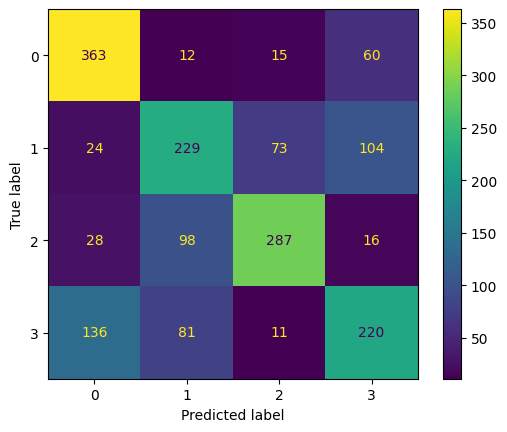

In [11]:
# Print confusion matrix for the model
cm = confusion_matrix(Y_test_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

In [12]:
all_feature_names = X.columns

In [13]:
from sklearn.tree import DecisionTreeClassifier, export_text


surrogate_model = DecisionTreeClassifier(max_depth=20)  # Control complexity with max_depth
surrogate_model.fit(X_test, Y_pred)

# Print the rules
tree_rules = export_text(surrogate_model, feature_names=all_feature_names)
print(tree_rules)

|--- num__vote_count <= -0.40
|   |--- num__runtime <= -0.21
|   |   |--- num__release_year <= -1.93
|   |   |   |--- genres__horror <= 0.50
|   |   |   |   |--- overview__help <= 0.06
|   |   |   |   |   |--- overview__people <= 0.22
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- overview__people >  0.22
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- overview__help >  0.06
|   |   |   |   |   |--- class: 0
|   |   |   |--- genres__horror >  0.50
|   |   |   |   |--- class: 0
|   |   |--- num__release_year >  -1.93
|   |   |   |--- genres__documentary <= 0.50
|   |   |   |   |--- genres__drama <= 0.50
|   |   |   |   |   |--- num__popularity <= 0.10
|   |   |   |   |   |   |--- num__revenue <= -0.30
|   |   |   |   |   |   |   |--- production_countries__republic <= 0.50
|   |   |   |   |   |   |   |   |--- overview__film <= 0.74
|   |   |   |   |   |   |   |   |   |--- tagline__life <= 0.81
|   |   |   |   |   |   |   |   |   |   |--- overview__living <= 0.4